## Parameter search experiments

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [112]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

Detected 6 clusters
Finished after 0:00:00.241427
Rate of noise in dataset: 0.187960


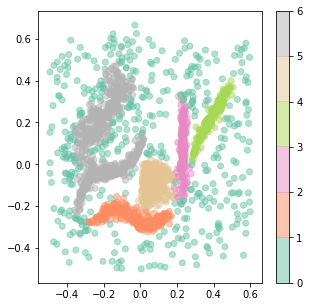

In [125]:
data = fuzzy
eps = 0.03
minPts = 10

# Fit
dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

In [124]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [114]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

Kann ich k von kMeans überhaupt verwenden? Ich muss ja schon ein k angeben für den consensus! -> ist natürlich dämlich. ^^ Wäre das Beste, was ich herausholen kann, evtl. dass ich beim consensus auch ein schlechtes k angeben kann, und es funktioniert immer noch? Oder gibt es auch eine consensus-Methode, bei der man die Anzahl der Cluster nicht angeben muss?

In [132]:
def plot_results(cl_objects, nmi_arr, consensus_obj, algorithm, mesh_x, mesh_y):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_x_param = len(np.unique(mesh_x))
    num_y_param = len(np.unique(mesh_y))
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param + 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.2}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
#                 print(mesh_eps)
#                 print(mesh_eps[cur_x, cur_y])
                ax.set_title('eps = {:.2}, minPts = {:}\nNMI = {:.2}'.format(mesh_x[cur_x, cur_y], mesh_y[cur_x, cur_y], nmi_arr[i-num_subplts_per_row]))
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    fig.savefig("bandwidth estimation.png")

## ALS NÄCHSTES:
+ 2d-param-search
+ behebe diese beknackte Warnung: C:\Users\Johannes\Desktop\Uni\Mathematische Aspekte in ML\Projekt\consensus - playing around afterwards\clustertools\models\consensus.py:202: RuntimeWarning: invalid value encountered in double_scalars
  return mutual_information / np.sqrt(entropy_a * entropy_b)

In [140]:
# Set parameters:

# General
data = fuzzy
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(0.01, 0.10, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 6
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

# KMeans
num_objects = 3
k_arr = np.arange(1,num_objects+1)

In [127]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.1, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:47.515194
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.21
Consensus clustering terminated.
Finished after 0:01:06.252895
ANMI (average normalized mutual information) of consensus with clusterings: 0.346
Calculate NMI's


In [145]:
importlib.reload(consensus)

<module 'consensus_clustering.consensus' from 'C:\\Users\\Johannes\\Desktop\\Uni\\Clustering-Paper\\consensus_clustering\\consensus_clustering\\consensus.py'>

In [146]:
nmi_arr_km, cl_objects_km, consensus_obj_km = param_search_kmeans(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr=k_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:46.617581
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.0
mutual information: 0.0
entropy a: -3066.0336309227146
entropy b: 0.0
mutual information: 1456.4315285456437
entropy a: -3066.0336309227146
entropy b: -1456.431528545644
mutual information: 2473.4407826231704
entropy a: -3066.0336309227146
entropy b: -2473.440782623171
Consensus clustering terminated.
Finished after 0:00:47.169058
ANMI (average normalized mutual information) of consensus with clusterings: 0.529
Calculate NMI's
mutual information: 0.0
entropy a: -3066.0336309227146
entropy b: 0.0
mutual information: 1456.4315285456437
entropy a: -3066.0336309227146
entropy b: -1456.431528545644
mutual information: 2473.4407826231704
entropy a: -3066.0336309227146
entropy b: -2473.440782623171


Number of clusterings: 36


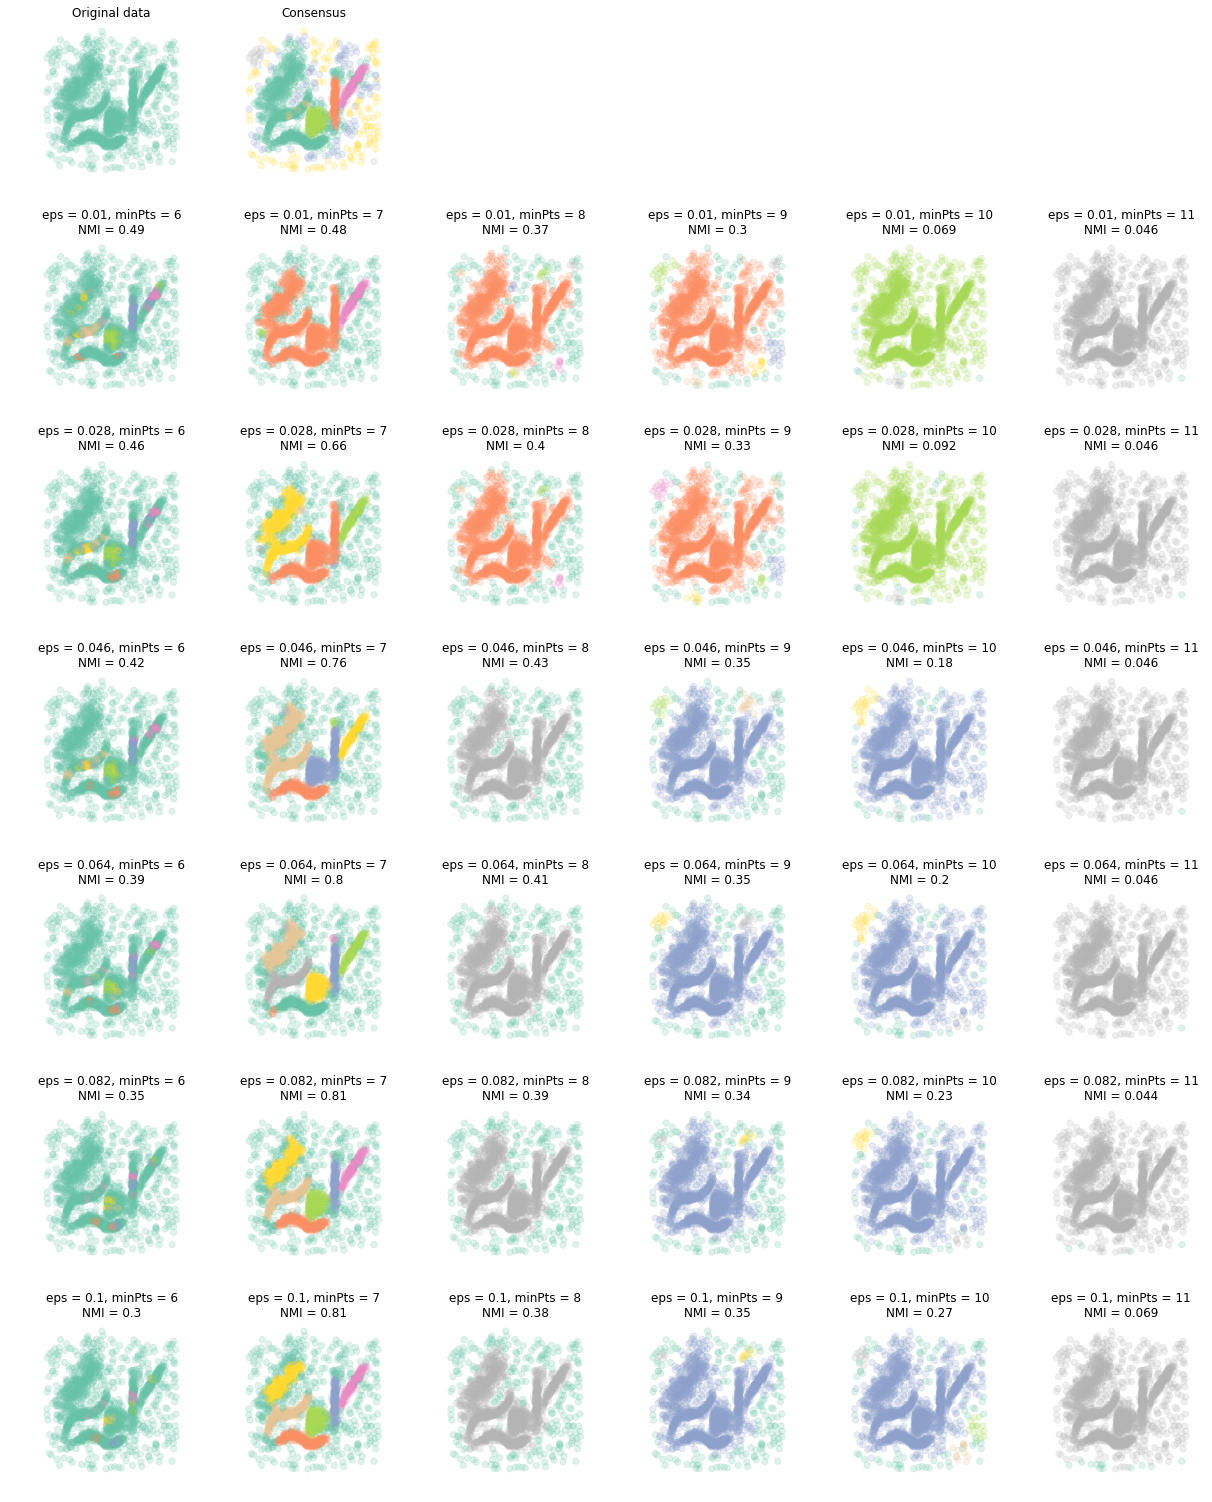

In [133]:
plot_results(cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='dbscan', mesh_x=mesh_eps, mesh_y=mesh_min_pts)

#### AHA das ist ein wirklich schönes Resultat! Die Parametersuche funktioniert auch, wenn das Optimum am Rand liegt, in 2D, obwohl ein Riesen Haufen Ramsch dabei ist, und obwohl der consensus nicht optimal ist!

Number of clusterings: 3


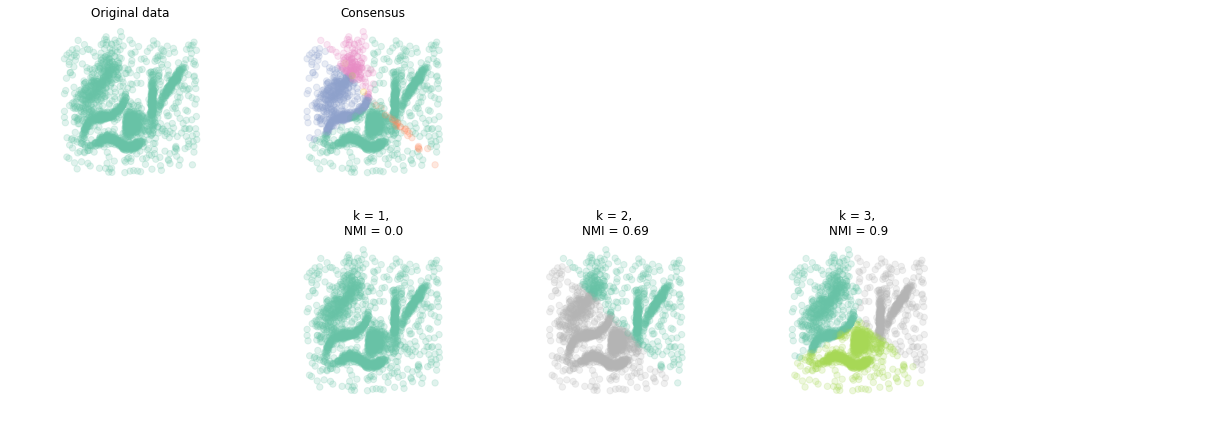

In [147]:
plot_results(cl_objects=cl_objects_km, nmi_arr=nmi_arr_km, consensus_obj=consensus_obj_km, algorithm='kmeans', mesh_x=k_arr, mesh_y=np.zeros(len(k_arr)))

#### für kmeans ist das hier ein blödes Beispiel, weil KMeans auf diesem Datensatz ja sowieso nicht funktioniert. Ich bräuchte einen Datensatz, für den man eine bestimmte Anzahl an Clustern finden muss, wo kmeans aber gut funktioniert. Vielleicht funktioniert dann Kmeans, auch wenn die Anzahl der consensus-cluster nicht optimal ist -> das gilt es, herauszufinden

## ToDo:
+ Spare eine NMI-Berechnung
+ Beschleunige NMI-Berechnung
+ Korrigiere bei der Entropie-Berechnung das Vorzeichen
+ Berichtige diese Punkte auch im alten Repo